# Data Exploration

Now that our NPZ data file is ready, let's use it and perform some data exploration.

And first of all, load the NPZ file and feed some variables we will need in this Notebook



In [1]:
import numpy as np
import os


In [2]:
# Load data from NPZ file

images={}
features={}
filenames={}

with np.load(os.path.join('data', 'data.npz')) as npz_file:
    dataset_name=npz_file['constant_value'][0]
    for name in dataset_name:
        print("Loading images from {} set".format(name))
        images[name]=npz_file['{}_data'.format(name)]
        print('  shape: {} - dtype: {}'.format(images[name].shape, images[name].dtype))
        print("Loading features from {} set".format(name))
        features[name]=npz_file['{}_features'.format(name)]
        print('  shape: {} - dtype: {}'.format(features[name].shape, features[name].dtype))
        print("Loading filenames from {} set".format(name))
        filenames[name]=npz_file['{}_filenames'.format(name)]
        print('  shape: {} - dtype: {}'.format(filenames[name].shape, filenames[name].dtype))

        print("\n")


        

Loading images from train set
  shape: (280, 299, 299, 3) - dtype: float64
Loading features from train set
  shape: (280, 2048) - dtype: float64
Loading filenames from train set
  shape: (280,) - dtype: <U30


Loading images from test set
  shape: (50, 299, 299, 3) - dtype: float64
Loading features from test set
  shape: (50, 2048) - dtype: float64
Loading filenames from test set
  shape: (50,) - dtype: <U30


Loading images from valid set
  shape: (139, 299, 299, 3) - dtype: float64
Loading features from valid set
  shape: (139, 2048) - dtype: float64
Loading filenames from valid set
  shape: (139,) - dtype: <U30




## Plot a few images from each category

I use random.randint() method to pickup 5 random images in all the dataset. I then use the trick described in the previous Notebook to display the images


5 random images from train dataset:


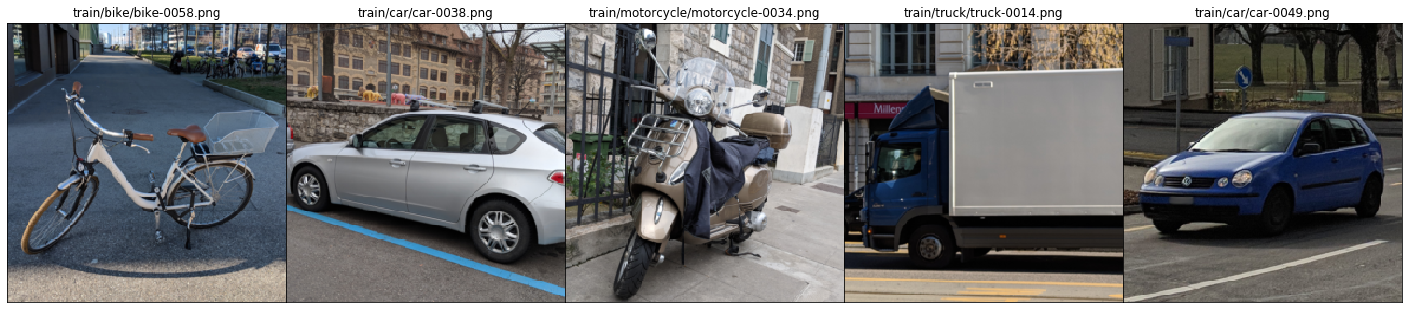


5 random images from test dataset:


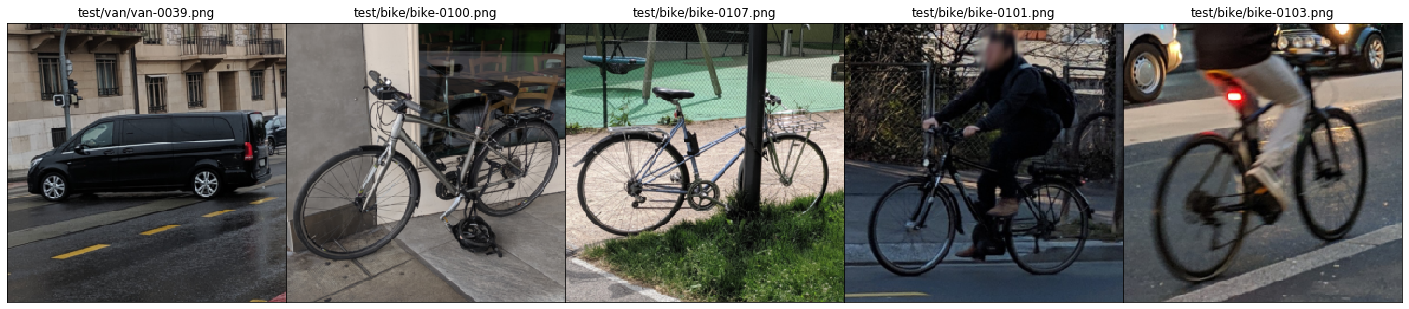


5 random images from valid dataset:


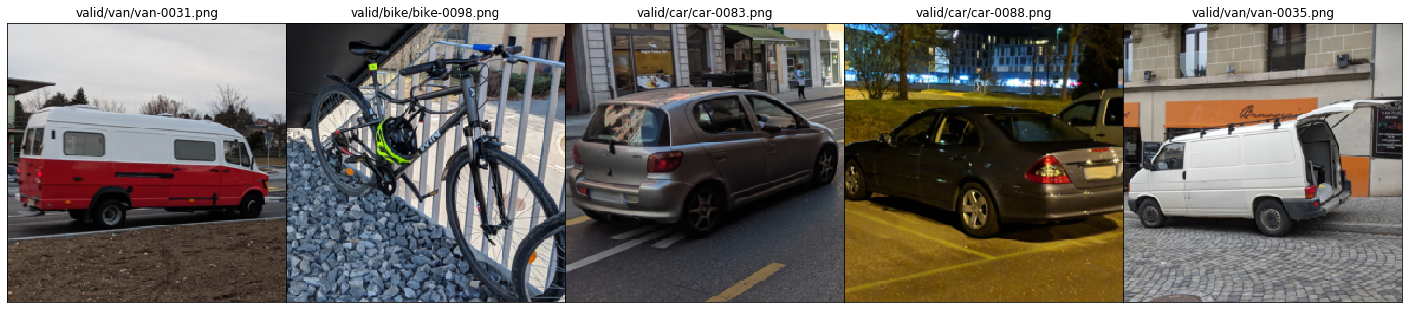

In [8]:
from random import randint


%matplotlib inline
import matplotlib.pyplot as plt


# Plot random images from each dataset
for name in dataset_name:
    print("\n5 random images from {} dataset:".format(name))
    
    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 10))

    # Remove gaps between suplots
    plt.subplots_adjust(wspace=0, hspace=0)

    for i, axis in enumerate(axes.flatten()):
        image_index=randint(0, len(images[name])-1)
        axis.imshow(np.array(images[name][image_index]*255, dtype=np.uint8))
        axis.get_xaxis().set_visible(False) # disable x-axis
        axis.get_yaxis().set_visible(False) # disable y-axis
        axis.set_title('{}/{}'.format(name, filenames[name][image_index]))
    
    plt.show()

## PCA exploration

In order to perform PCA exploration, I will work with the train high-level features.

I will first normalize them using a StandardScaler and then, fit a PCA using None as number of components. As we are seeking for the % of variance per number of components, using this strategy will permit us to identify the number of components needed to get a certain % of total variance contained in this number of components.

To seek this %, after fitting the PCA, I will use its *explained_variance_ratio_* to get a list of % of variance each feature covers. This array will be used at first to build a scree plot.


In [150]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X=scaler.fit_transform(features['train'])


pca=PCA(n_components=None)

pca.fit(X, y=None)

# Proportion of variance explained
pve = pca.explained_variance_ratio_


## Build a scree plot

Now that the *explained_variance_ratio_* is ready, we can draw a scree plot with it.

> Note: The following code as been grabbed from the courses

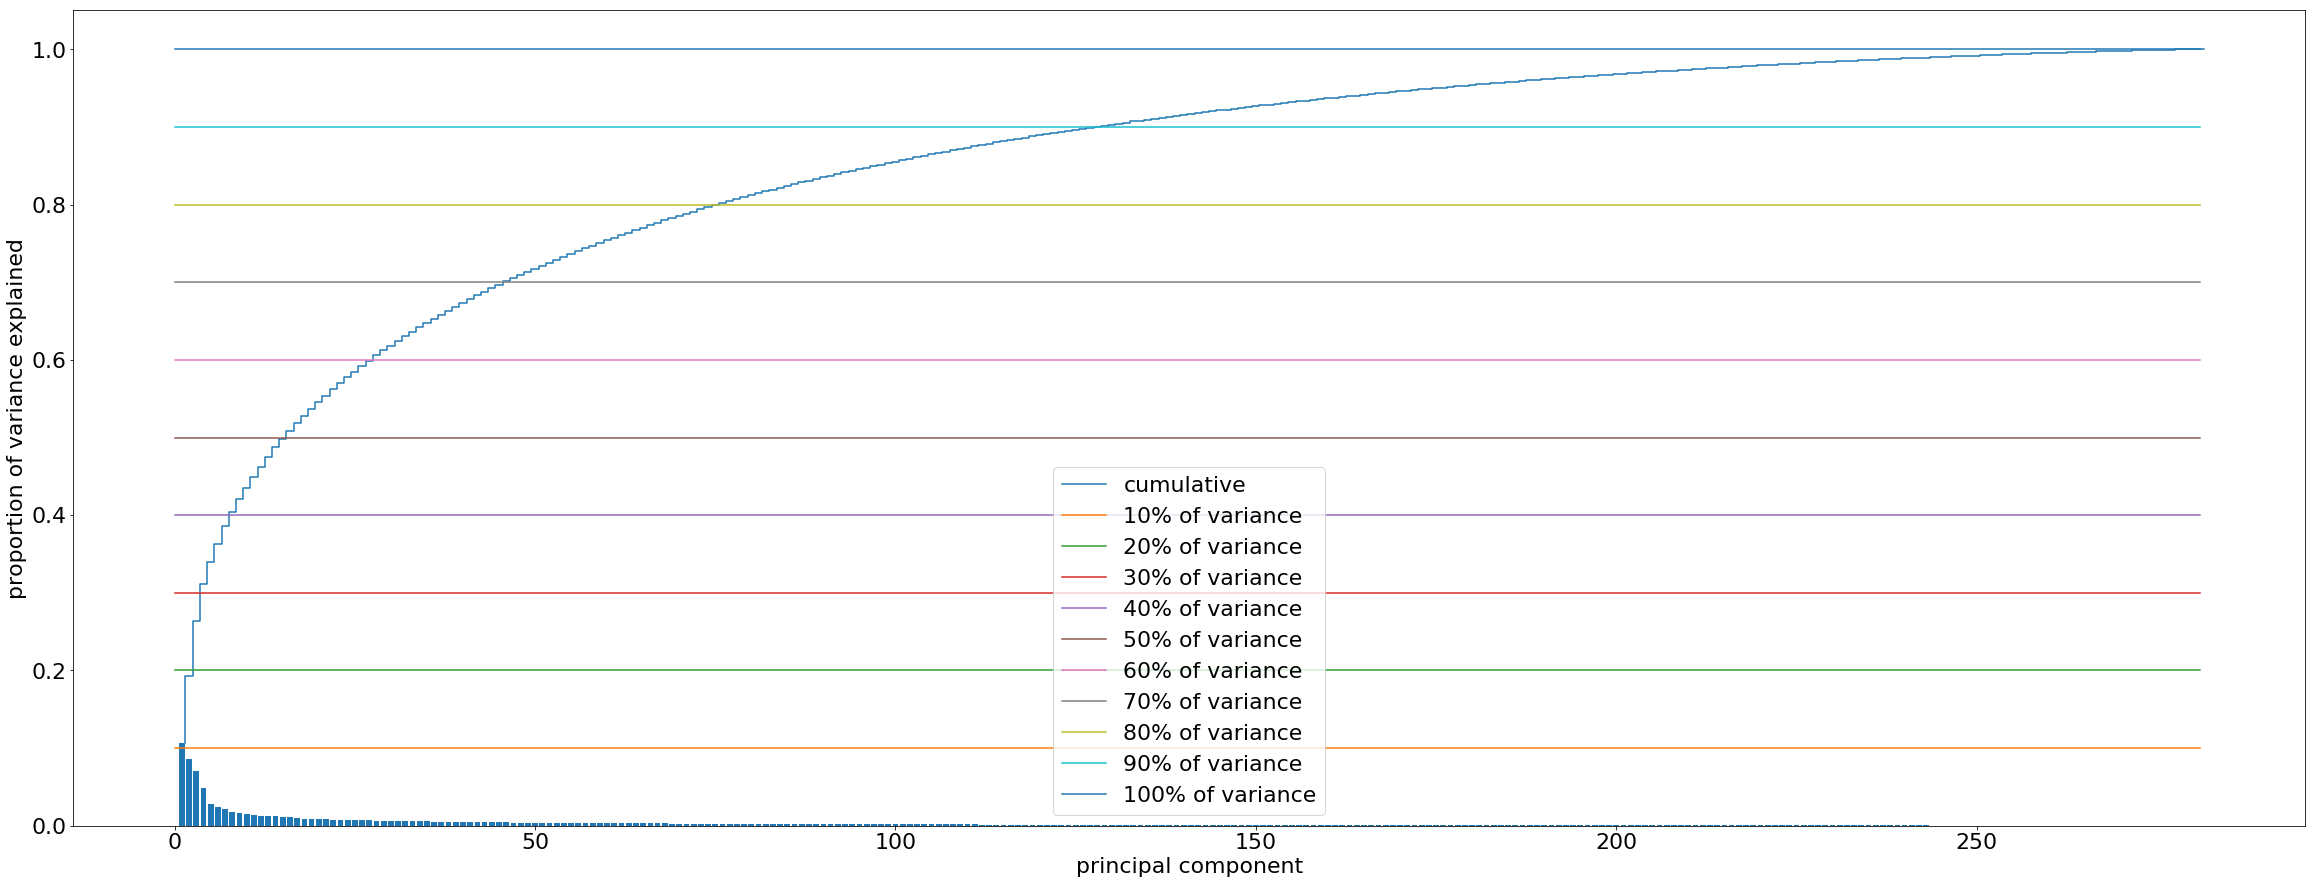

In [151]:
plt.figure(figsize=(40,15))
plt.rcParams.update({'font.size': 22})

# Create bar plot
plt.bar(xcor, pve)


# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, # 1.5,2.5,..,n_components+0.5
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

for i in np.arange(0.1, 1.1, 0.1).tolist():
    plt.plot([0,len(X)], [i, i], label='{}% of variance'.format(int(i*100)))

plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')
plt.legend()
plt.show()

## How many PCA components explain 10%, 20%, …, 90% and 100% of the variance?

In the following graph, I've plotted horizontal lines correspondig to the 10%, 20%, ..., 90% and 100% of the variance. It's quite easy to answer to some of them how many components are needed to cover a certain % of variance:

* 10%: One component is enough
* 20*: Three compnents
* 30%: Four components
* 40%: Height components

Other values are difficult to read, appart if we draw a really high resolution graph.

Even if an higer resolution could work, counting the number of components that gets 80% of the variance will be very tricky. Let's choose another approach: Iterate over the *explained_variance_ratio_* array, sum its elements one by one, and check each time the sum reach the % we are looking for. The number of components we have in the sum are the number of components needed to cover the % of variance.


In [152]:
# sum of components
sum_total=0

# number of components in the sum
nb_components=0

# Percentage level we are looking for
percentage_level=np.arange(0.1, 1.2, 0.1).tolist()

# index of the percentage level
percentage_index=0

print("Number of PCA components that explain 10%, 20%, …, 90% and 100% of the variance")
print("Total number of components:", len(pve))

# for each entry in pve
for i in pve:
    # sum current entry to total
    sum_total+=i
    
    # Increment counter of components
    nb_components+=1
    
    # Did we reach our current percentage limit ?
    if sum_total>percentage_level[percentage_index]:
        # Print % and nb_components
        print('{:3.0f}% => {:3.0f} components'.format(percentage_level[percentage_index]*100, nb_components))
        
        # select the next percentage index
        percentage_index+=1


Number of PCA components that explain 10%, 20%, …, 90% and 100% of the variance
Total number of components: 281
 10% =>   1 components
 20% =>   3 components
 30% =>   4 components
 40% =>   8 components
 50% =>  16 components
 60% =>  28 components
 70% =>  46 components
 80% =>  76 components
 90% => 128 components
100% => 279 components


Surprisingly, the 100% of the variance is contained in all the component minus 1 (the last one). That sounds strange as the 100% of variance is obtain when considering all of the components, not all minus one.

So, where is the error ?

In fact, the last value of the pve array is a very, very small number (1.4438983153316816e-33), and I suppose that on the platform I use (Apple Silicon M1), the float precision is not sufficient and in the precedent algorithm, when I perform the test *sum_total>percentage_level[percentage_index]*, the rounding error made by the CPU returns a TRUE value when reaching the 279th feature.

In [153]:
pve[280]

1.4438983153316816e-33

## Visualize the features on a 2d-plot with PCA using the first two components. What can you say about the results?

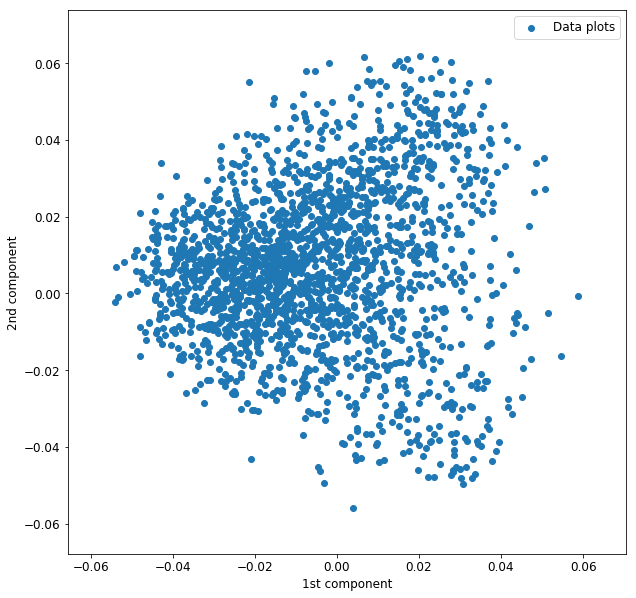

In [172]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 12})

plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.scatter(pca.components_[0], pca.components_[1], label='Data plots')
plt.legend()
plt.show()


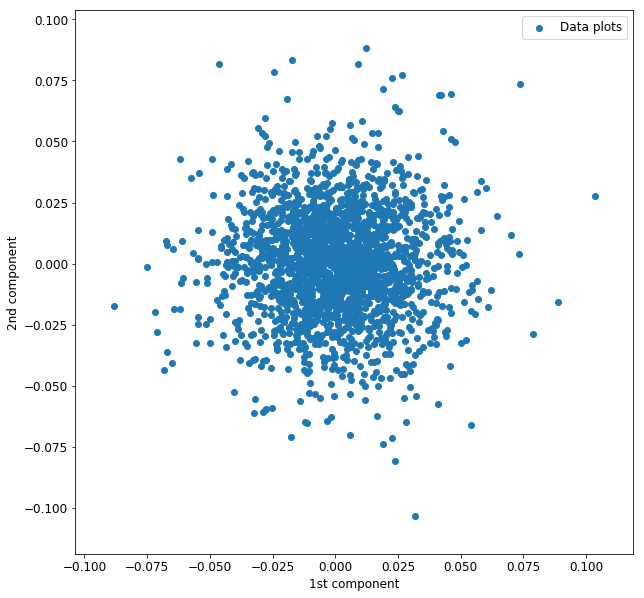

In [176]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 12})

plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.scatter(pca.components_[275], pca.components_[276], label='Data plots')
plt.legend()
plt.show()